# Advanced Lane Finding

## Overview

This notebook contains an implementation to identify the lane boundaries in a video from a front-facing camera on a car. The camera calibration images, test road images, and project videos are located in this [repository](https://github.com/abmantha/CarND-Advanced-Lane-Lines.git)

* The goals / steps of this project are the following:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.
---

### Imports

In [6]:
import numpy as np
import cv2
import sklearn
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

### 1. Camera Calibration

__Finding Chessboard Corners__

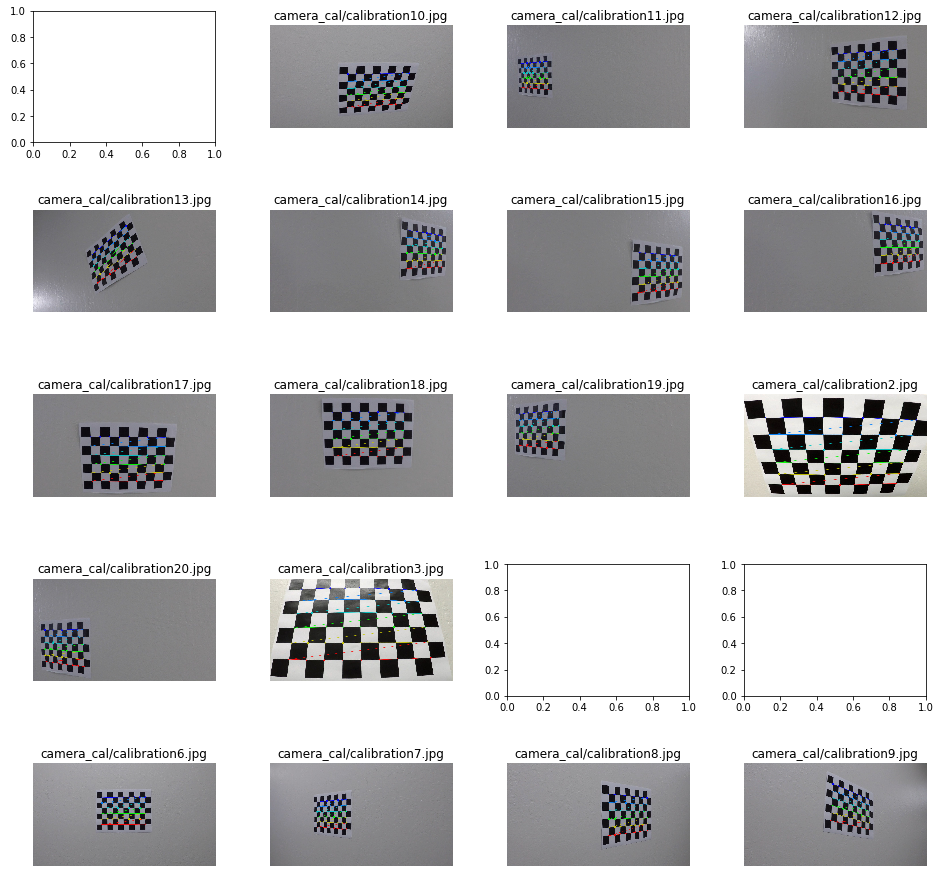

In [7]:
# Create objpoints and imgpoints data from calibration images
%matplotlib qt
%matplotlib inline

images_files = glob.glob("camera_cal/calibration*.jpg")
nx = 9
ny = 6

def get_calibration_points(images, nx, ny): 
    objpoints = [] # Known object coordinates for chessboard
    imgpoints = []

    objp = np.zeros((ny*nx,3), np.float32) 

    # x, y coordinates 
    # mgrid returns coordinates for a given grid size
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2)

    figure, axis = plt.subplots(5, 4, figsize=(16, 16))
    figure.subplots_adjust(hspace=0.4, wspace=0.3)
    axis = axis.ravel()
    for index, fname in enumerate(images):
        # Read in a new image
        img = mpimg.imread(fname)
        
        # Convert image to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)

        # If corners are found, add object points, image points
        if ret == True: 
            imgpoints.append(corners)
            objpoints.append(objp)
            img_with_chessboard = cv2.drawChessboardCorners(img, (nx,ny), corners, ret)

            axis[index].set_title(fname)
            axis[index].axis('off')
            axis[index].imshow(img_with_chessboard)
            
    return objpoints, imgpoints


objpoints, imgpoints = get_calibration_points(images_files, nx, ny)

### 2. Distortion Correction

#### Utility Functions

In [8]:
# Only need to apply this to a single image to retrieve calibration values
def calibrate_camera(image, objpoints, imgpoints): 
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape, None, None)
    return ret, mtx, dist, rvecs, tvecs

# Apply this to each image when undistortion
def undistort(image, mtx, dist): 
    undistort = cv2.undistort(image, mtx, dist, None, mtx)
    return undistort

#### Undistortion of Calibration Images

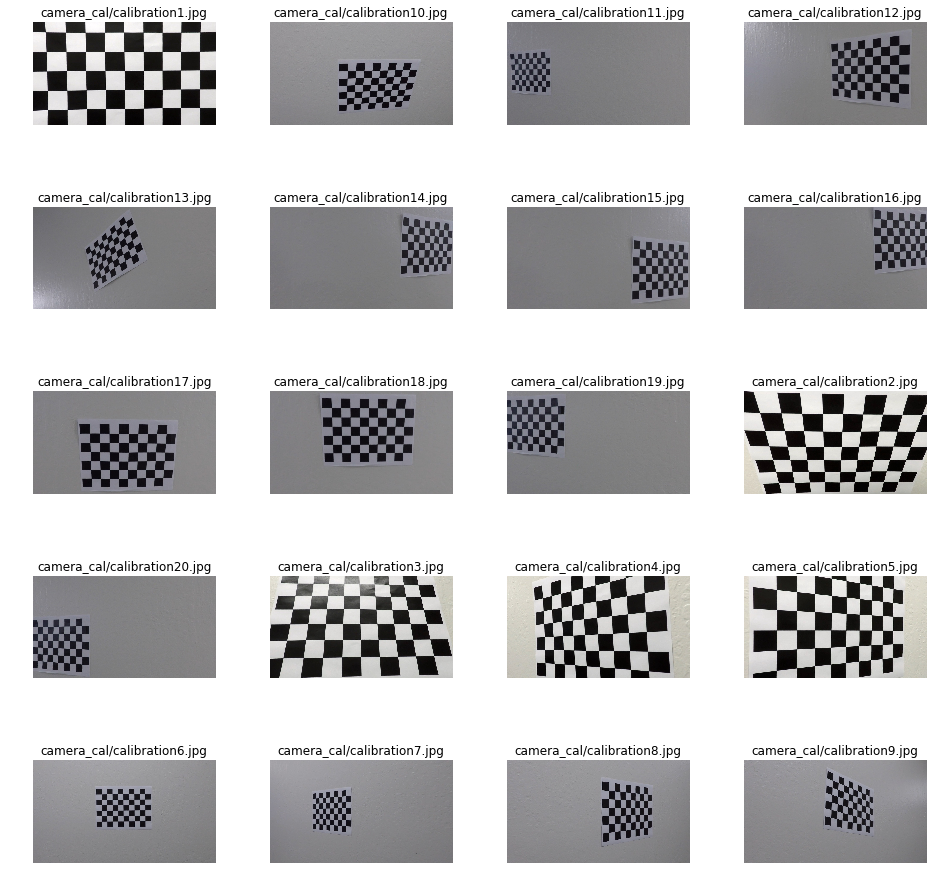

In [9]:
calibration_image = mpimg.imread(images_files[0])
ret, mtx, dist, rvecs, tvecs = calibrate_camera(calibration_image, objpoints, imgpoints)

figure, axis = plt.subplots(5, 4, figsize=(16, 16))
figure.subplots_adjust(hspace=0.4, wspace=0.3)
axis = axis.ravel()

for i, fname in enumerate(images_files): 
    img = mpimg.imread(fname)
    undistorted = undistort(img, mtx, dist)
    axis[i].set_title(fname)
    axis[i].axis('off')
    axis[i].imshow(undistorted)

#### Undistortion of Examples Images

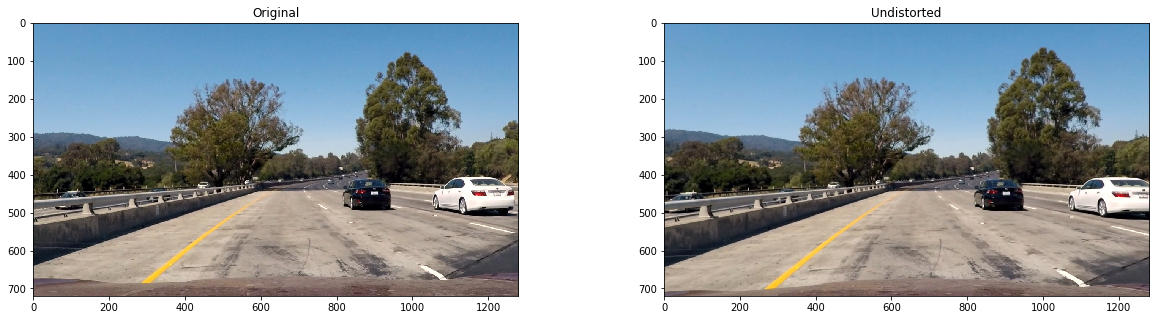

In [10]:
example_image = mpimg.imread("test_images/test1.jpg")
undistorted_example_image = undistort(example_image, mtx, dist)
figure, (axis1, axis2) = plt.subplots(1, 2, figsize=(20, 15))
figure.subplots_adjust(hspace=0.4, wspace=0.3)
axis1.set_title("Original")
axis1.imshow(example_image)
axis2.set_title("Undistorted")
axis2.imshow(undistorted_example_image)

### 3. Color/Gradient Thresholding

In [11]:
def abs_sobel_threshold(image, orient='x', sobel_kernel=3, threshold=(0, 255)): 
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient='x' or 'y'
    xorder = 1 if orient == 'x' else 0
    sobel = cv2.Sobel(gray, cv2.CV_64F, xorder, not xorder, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the derivative
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then conver to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel / np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > threshold[0] and < threshold[1]
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    
    return binary_output

def magnitude_threshold(image, sobel_kernel=3, threshold=(0, 255)): 
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    sobel_x2 = np.square(sobel_x)
    sobel_y2 = np.square(sobel_y)
    abs_sobel_xy = np.sqrt(sobel_x2 + sobel_y2)
    
    # 4) Scale to 8-bit (0 - 255) then conver to type = np.uint8
    scaled_sobel = np.uint8(255 * abs_sobel_xy / np.max(abs_sobel_xy))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > threshold[0] and < threshold[1]
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= threshold[0]) & (scaled_sobel <= threshold[1])] = 1
    
    return binary_output
 

def direction_threshold(image, sobel_kernel=3, threshold=(0, np.pi/2)): 
    # 1) Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x and y
    sobel_x = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobel_y = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute x and y gradients
    abs_sobel_x = np.square(sobel_x)
    abs_sobel_y = np.square(sobel_y)
    
    # 4) Calculate the direction of gradient
    dir_sobel = np.arctan2(abs_sobel_y, abs_sobel_x)
    
    # 5) Create a mask of 1's where the scaled gradient magnitude is > threshold[0] and < threshold[1]
    binary_output = np.zeros_like(dir_sobel)
    binary_output[(dir_sobel >= threshold[0]) & (dir_sobel <= threshold[1])] = 1
    
    return binary_output

### Testing threshold techniques

#### Gradient for individual x, y orientation; magnitude gradient, direction gradient

In [72]:
def plot_gradient_thresholds(fname):
    image = mpimg.imread(fname)
    undistorted_example_image = undistort(image, mtx, dist)
    threshold = (180, 255)
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    abs_sobel_x = abs_sobel_threshold(image, 'x', 3, (50, 100))
    abs_sobel_y = abs_sobel_threshold(image, 'y', 3, (50, 100))
    magnitude_sobel = magnitude_threshold(image, 9, (30, 100))
    direction_sobel = direction_threshold(image, 17, (0.7, 1.3))
    binary_gray = np.zeros_like(gray)
    binary_gray[(gray > threshold[0]) & (gray <= threshold[1])] = 1
    combined = np.zeros_like(direction_sobel)
    combined[((abs_sobel_x == 1) & (abs_sobel_y == 1)) | ((magnitude_sobel == 1) & (direction_sobel == 1))] = 1

    # Plotting thresholded images
    f, axs = plt.subplots(3, 3, figsize=(20,10))
    axs = axs.ravel()
    
    axs[0].set_title(fname)
    axs[0].imshow(image)

    axs[1].set_title('Gradient -- x-oriented')
    axs[1].imshow(abs_sobel_x, cmap='gray')

    axs[2].set_title('Gradient -- y-oriented')
    axs[2].imshow(abs_sobel_y, cmap='gray')

    axs[3].set_title(fname)
    axs[3].imshow(image)

    axs[4].set_title('Magnitude Threshold')
    axs[4].imshow(magnitude_sobel, cmap='gray')

    axs[5].set_title('Direction Threshold')
    axs[5].imshow(direction_sobel, cmap='gray')

    axs[6].set_title(fname)
    axs[6].imshow(image)
    
    axs[7].set_title('Gray Thresholded')
    axs[7].imshow(binary_gray, cmap='gray')

    axs[8].set_title('Combined Magnitude and Direction Gradient')
    axs[8].imshow(combined, cmap='gray')
    
def plot_converted_color_space_thresholds(fname, flag): 
    image = mpimg.imread(fname)
    undistorted_example_image = undistort(image, mtx, dist)
    
    threshold = (90, 255)
    converted_color_space = cv2.cvtColor(image, flag)
    channel_1 = converted_color_space[:, :, 0]
    channel_2 = converted_color_space[:, :, 1]
    channel_3 = converted_color_space[:, :, 2]
    
    binary_1 = np.zeros_like(channel_1)
    binary_2 = np.zeros_like(channel_2)
    binary_3 = np.zeros_like(channel_3)
    
    binary_1[(channel_1 > threshold[0]) & (channel_1 <= threshold[1])] = 1
    binary_2[(channel_2 > threshold[0]) & (channel_2 <= threshold[1])] = 1
    binary_3[(channel_3 > threshold[0]) & (channel_3 <= threshold[1])] = 1
    
    f, axs = plt.subplots(2, 4, figsize=(20, 10))
    axs = axs.ravel()
    
    axs[0].set_title(fname)
    axs[0].imshow(image)
    
    axs[1].set_title('1')
    axs[1].imshow(channel_1)
    
    axs[2].set_title('2')
    axs[2].imshow(channel_2)
    
    axs[3].set_title('3')
    axs[3].imshow(channel_3)
    
    axs[4].set_title(fname)
    axs[4].imshow(image)
    
    axs[5].set_title('Channel 1 Threshold')
    axs[5].imshow(binary_1, cmap='gray')
    
    axs[6].set_title('Channel 2 Threshold')
    axs[6].imshow(binary_2, cmap='gray')
    
    axs[7].set_title('Channel 3 Threshold')
    axs[7].imshow(binary_3, cmap='gray')
    
def plot_combined_thresholds(fname, orientation, sobel_threshold, sobel_kernel, flag, c, color_threshold):
    image = mpimg.imread(fname)
    
    if orientation == 'x' or orientation == 'y': 
        sobel_binary = abs_sobel_threshold(image, orientation, sobel_kernel, sobel_threshold)
    elif orientation == 'm': 
        sobel_binary = magnitude_threshold(image, sobel_kernel, sobel_threshold)
    elif orientation == 'd': 
        sobel_binary = direction_threshold(image, sobel_kernel, sobel_threshold)
        
    # Threshold color channel
    converted_color_space_image = cv2.cvtColor(image, flag)
    channel = converted_color_space_image[:, :, c]
    channel_binary = np.zeros_like(channel)
    channel_binary[(channel >= color_threshold[0]) & (channel <= color_threshold[1])] = 1

    # Stack each channel to view their individual contributions in green and blue respectively
    # This returns a stack of the two binary images, whose components you can see as different colors
    color_binary = np.dstack(( np.zeros_like(sobel_binary), sobel_binary, channel_binary))

    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sobel_binary)
    combined_binary[(sobel_binary == 1) | (channel_binary == 1)] = 1

    # Plotting thresholded images
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
    ax1.set_title(fname + ' -- Stacked thresholds')
    ax1.imshow(color_binary)

    ax2.set_title('Gradient: ' + orientation + '--' + 'Color Space: ' + str(flag) + '--' + 'Color Channel: ' + str(c))
    ax2.imshow(combined_binary, cmap='gray')

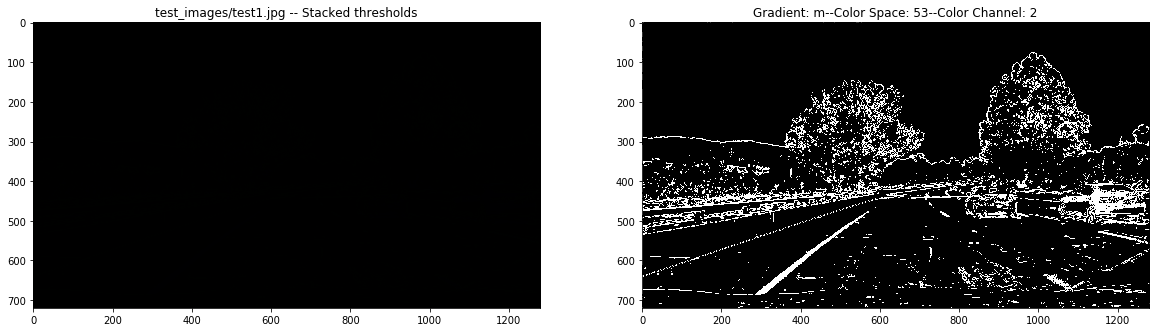

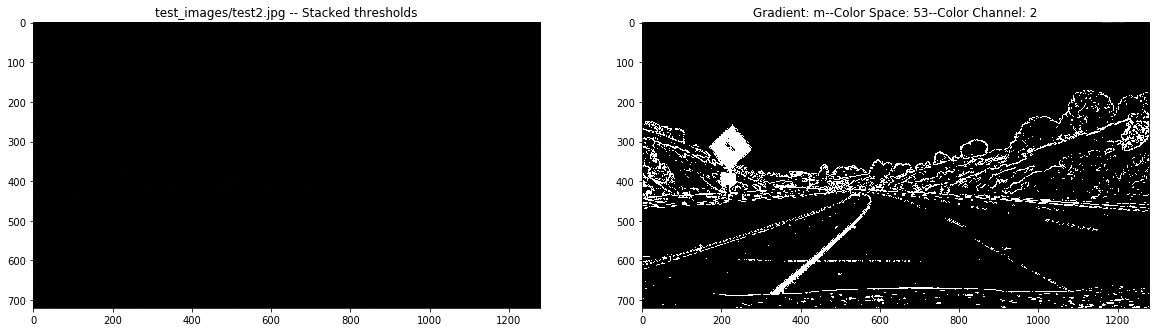

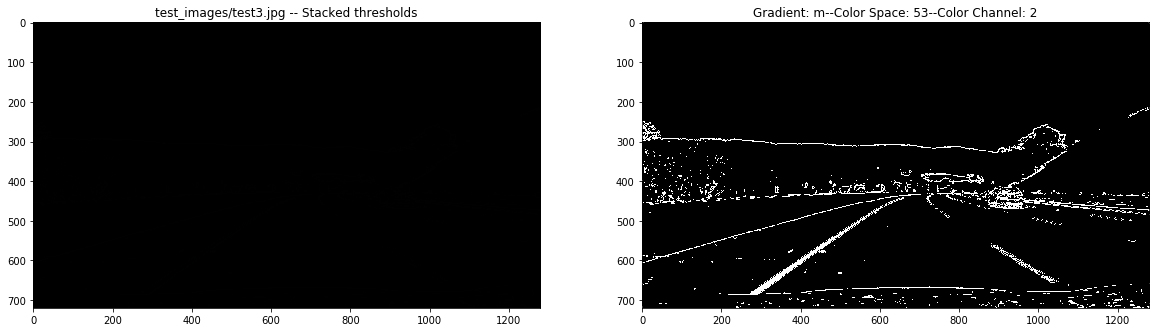

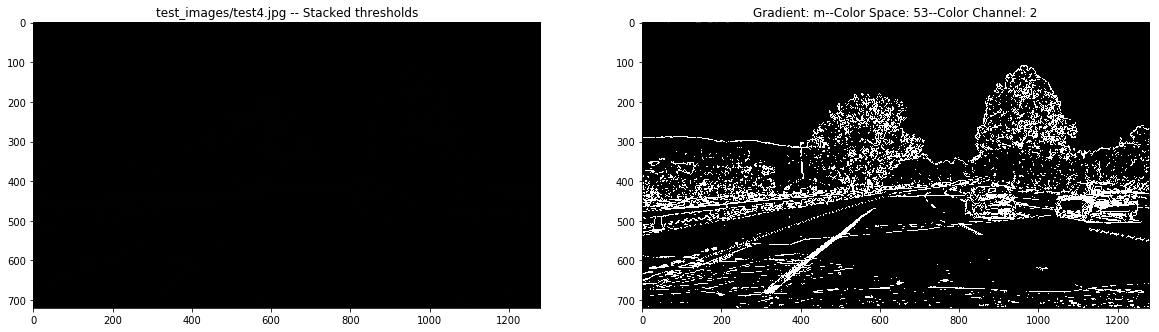

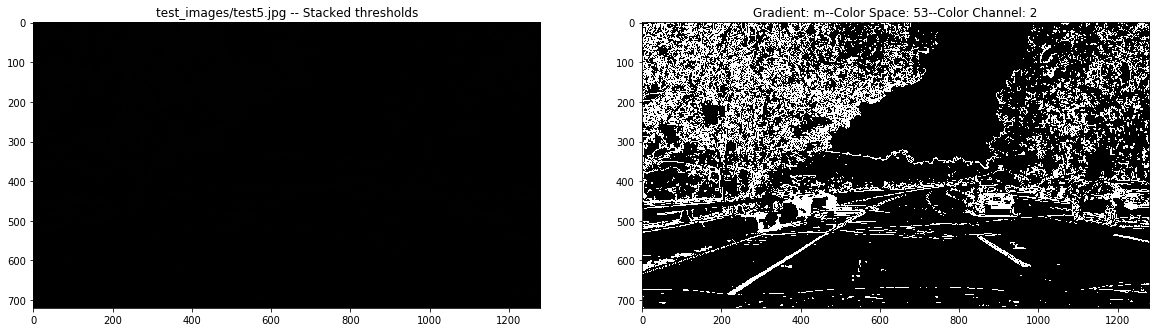

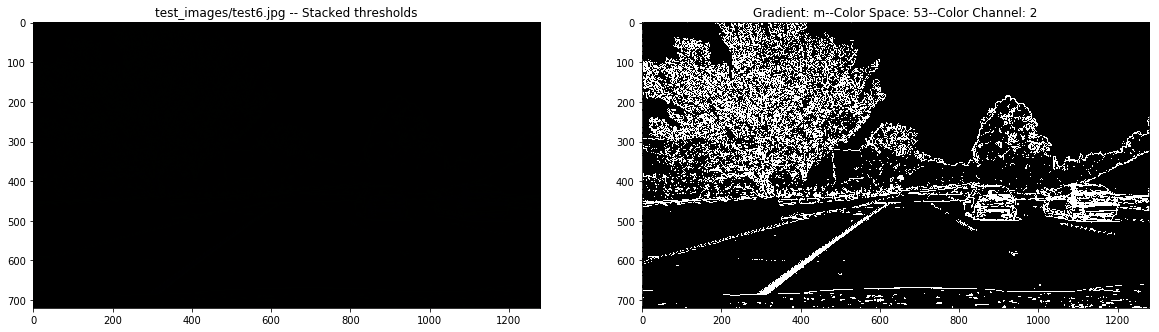

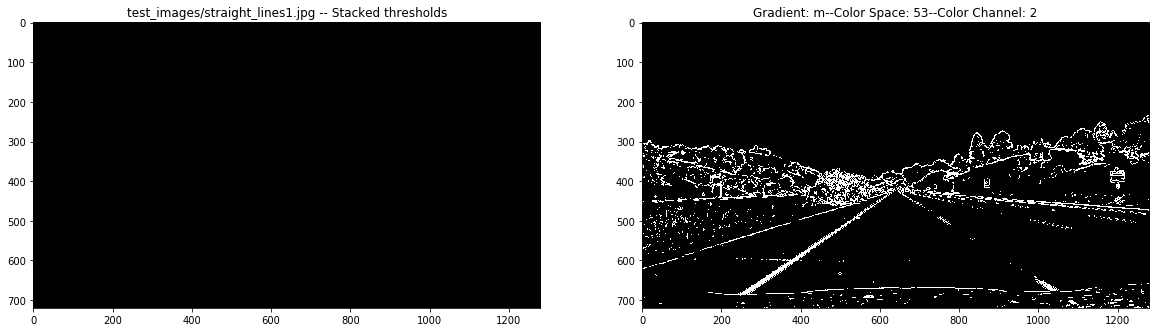

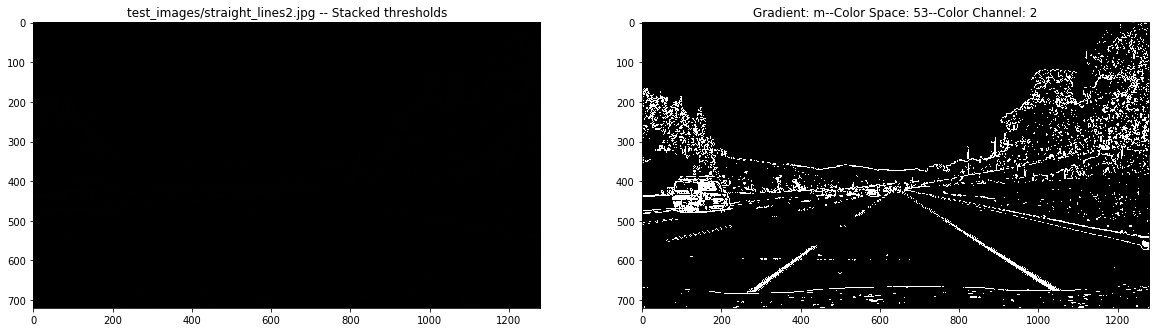

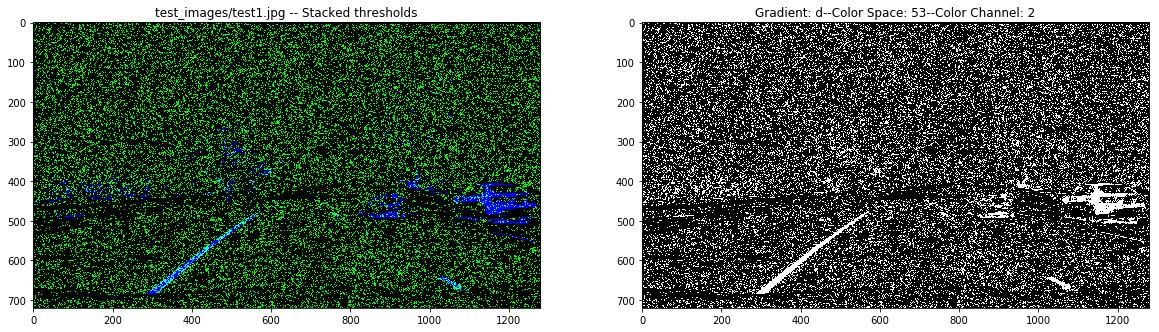

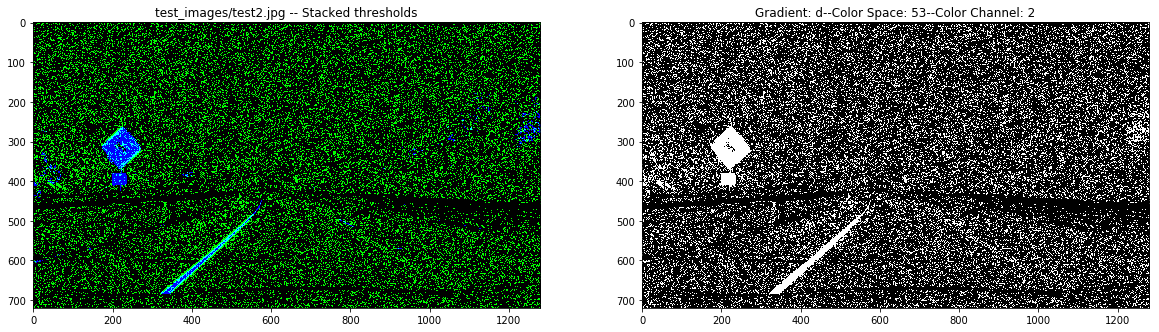

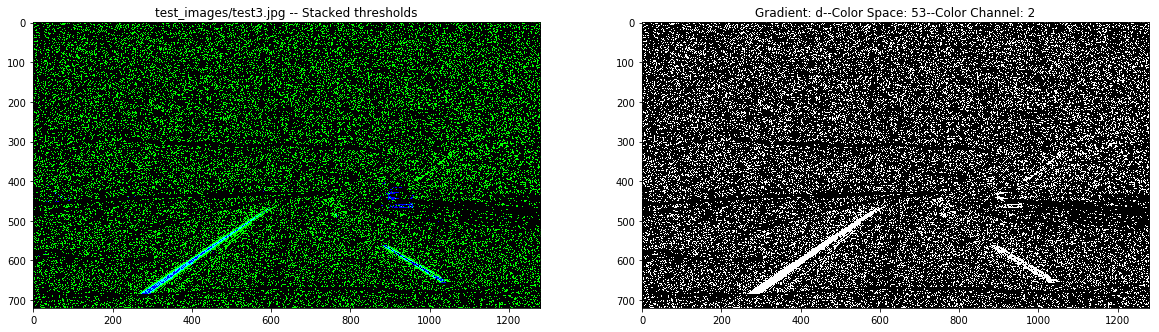

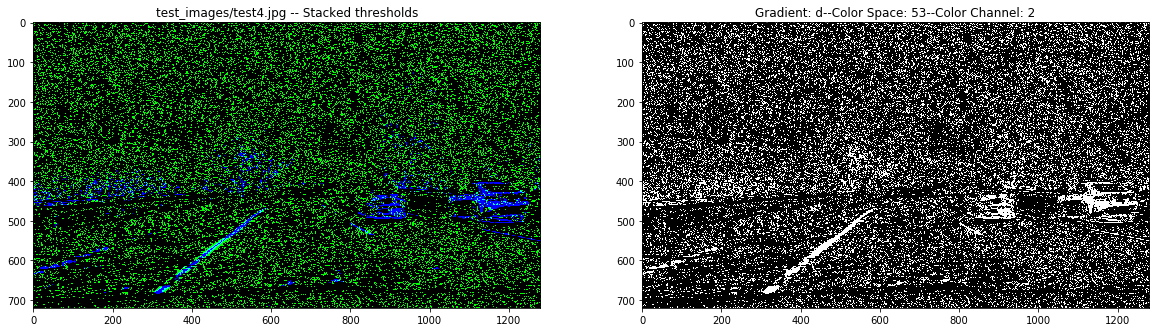

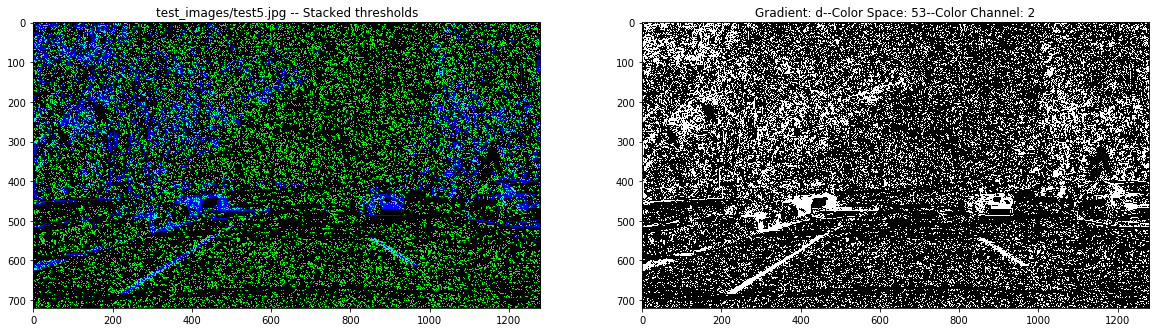

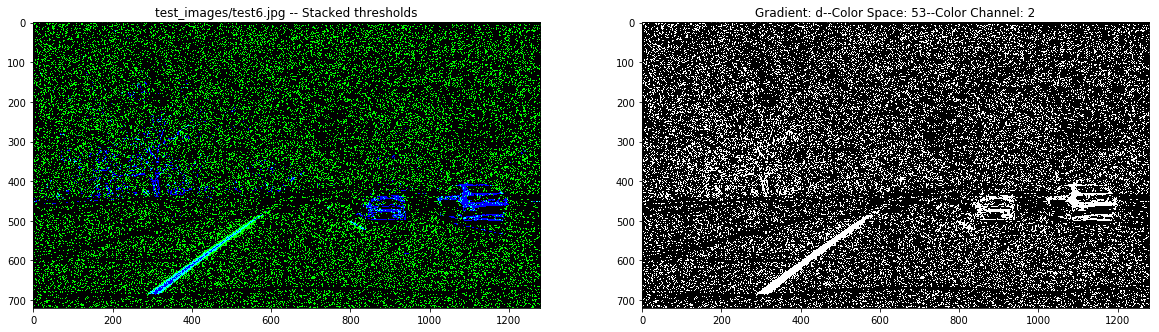

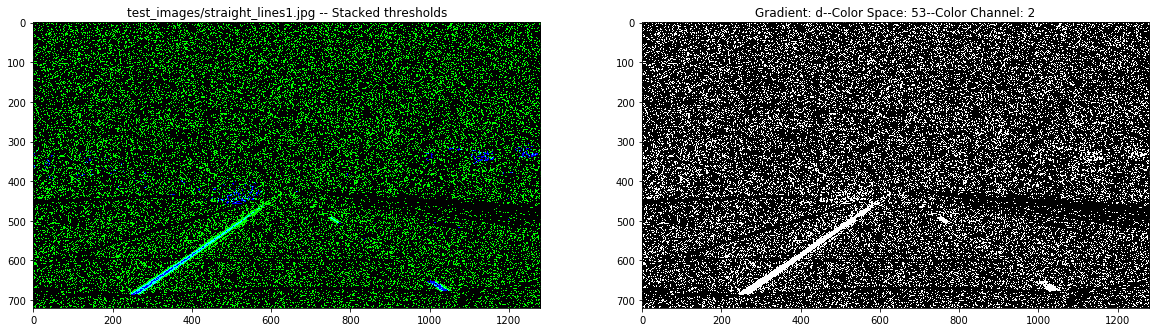

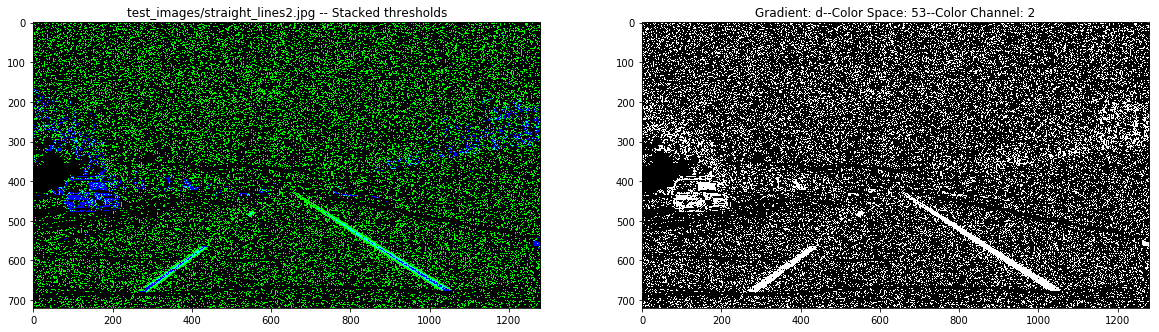

In [85]:
# plot_gradient_thresholds("test_images/test1.jpg")
# plot_converted_color_space_thresholds("test_images/test1.jpg", cv2.COLOR_RGB2HSV)
# plot_converted_color_space_thresholds("test_images/test1.jpg", cv2.COLOR_RGB2HLS)
# plot_combined_thresholds("test_images/test6.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 0, (170, 255))
# plot_combined_thresholds("test_images/test6.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 1, (170, 255))

plot_combined_thresholds("test_images/test1.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test2.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test3.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test4.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test5.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test6.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/straight_lines1.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/straight_lines2.jpg", 'm', (30, 100), 3, cv2.COLOR_RGB2HLS, 2, (170, 255))

plot_combined_thresholds("test_images/test1.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test2.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test3.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test4.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test5.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/test6.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/straight_lines1.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))
plot_combined_thresholds("test_images/straight_lines2.jpg", 'd', (0.7, 1.3), 7, cv2.COLOR_RGB2HLS, 2, (170, 255))

#### Promising Combinations: 
* Magnitude Gradient (30 - 100, 7|9|11|13) + HLS (S, 170-255)
* Direction Gradient (30 - 100, 3|5) + HLS (S, 170 - 255)

### 4. Perspective Transform

In [86]:
# gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(0, 255))
# grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(0, 255))
# mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(0, 255))
# dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0, np.pi/2)

def apply_perspective_transform(image, nx, ny, mtx, dist): 
    # 1) Undistort image using mtx and dist
    undistorted = cv2.undistort(image, mtx, dist, None, mtx)
    
    # 2) Convert to grayscale
    gray = cv2.cvtColor(undistorted, cv2.COLOR_RGB2GRAY)
    
    # 3) Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    
    # 4) If corners found: 
    if ret == True: 
        # 1) Define an offset
        offset = 100
        image_size = (gray.shape[1], gray.shape[0])
        
        # b) Define 4 source points
        src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
        
        # c) Define 4 destination points
        dest = np.float([[offset,offset], [image_size[0]-offset,offset],
                         [image_size[0]-offset,image_size[1]-offset],
                         [offset,image_size[1]-offset]])
        
        # d) Get the transform matrix
        M = cv2.getPerspectiveTransform(src, dest)
        
        # e) Apply transform matrix to produce perspective-transformed image
        warped_image = cv2.warpPerspective(undistorted, M, image_size, flags=cv2.INTER_LINEAR)
    
    return warped_image, M

### 5. Lane finding and Measuring Radius of Curvature -- Tracking

In [87]:
# Stores characteristics of each line detection
# Create an instance for the left and right lanesb
class Line(): 
    def __init__(self): 
        # was the line detected in the last iteration
        self.detected = False
        
        # x values of the last n fits of line
        self.recent_xfitted = [] 
        
        # average x values of the fitted line over the last n iterations
        self.bestx = None
        
        # polynomial coefficients averaged over last n iterations
        self.best_fit = None
        
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        
        # distance in meters of vehicle center from the line
        self.line_base_pos = None
        
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0, 0, 0], dtype='float')
        
        # x values for detected line pixels
        self.allx = None
        
        # y values for detected line pixels
        self.ally = None

### Lane Finding Method: Peaks in a Histogram & Sliding Window

In [ ]:
# Take the histogram of the bottom half of the image
histogram = np.sum(binary_warped[binary_warped.shape[0]/2:, :], axis=0)

# Create an output image to draw on and visualize the result
out_image = np.dstack((binary_warped, binary_warped, binary_warped)) * 255

# Find the peak of the left ad right halves of the histogram
# These are the starting points for left and right lines
midpoint = np.int(histogram[0]/2)
left_x_base = np.argmax(histogram[:midpoint])
right_x_base = np.argmax(histogra[midpoint:])

# Number of sliding windows
n_sliding_windows = 9

# Set the height of the windows
window_height = np.int(binary_warped.shape[0] / n_sliding_windows)

# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])

# Current positions to be updated for each window
left_x_current = left_x_base
right_x_current = right_x_base

# Width of windows +/- margin
margin = 100

# Minimum number of pixels found to recenter window
minpix = 50

# Create empty lists to receive left and right lane pixel indices
left_lane_indices = []
right_lane_indicces = []

# Step through windows one by one
for window in range(n_sliding_windows): 
    # Identify window boundaries in x and y (for both left and right)
    window_y_low = binary_warped.shape[0] - (window + 1) * window_height
    window_y_high = binary_warped.shape[0] - window * window_height
    window_x_left_low = left_x_current - margin
    window_x_left_high = left_x_current + margin
    window_x_right_low = right_x_current - margin
    window_x_right_high = right_x_current + margin
    
    # Draw the windows on the visualization
    cv2.rectangle(out_image, (window_x_left_low, window_y_low), (window_x_left_high, window_y_high), (0, 255, 0), 2)
    cv2.rectangle(out_image, (window_x_right_low, window_y_low), (window_x_right_high, window_y_high), (0, 255, 0), 2)
    
    # Identify the nonzero pixels in x and y within the window
    good_left_indices = ((nonzero_y >= window_y_low) & (nonzero_y < window_y_high) & 
                         (nonzero_x >= window_x_left_low) & (nonzero_x < window_x_left_high)).nonzero()[0]
    good_right_indices = ((nonzero_y > window_y_low) & (nonzero_y < window_y_high) &
                         (nonzero_x >= window_x_right_low) & (nonzero_x < window_x_right_high)).nonzero()[0]
    
    # Append these indices to the lists
    left_lane_indices.append(good_left_indices)
    right_lane_indices.append(good_right_indices)
    
    # If you found > minpix pixels, recenter the next window on their mean position
    if len(good_left_indices) > minpix: 
        left_x_current = np.int(np.mean(nonzero_x[good_left_indices]))
        
    if len(good_right_indices) > minpix: 
        right_x_current = np.int(np.mean(nonzero_x[good_right_indices]))
        
# Concatenate the arrays of indices
left_lane_indices = np.concatenate(left_lane_indices)
right_lane_indices = np.concatenate(right_lane_indices)

# Extract left and right pixel positions
left_x = nonzero_x[left_lane_indices]
left_y = nonzero_y[left_lane_indices]
right_x = nonzero_x[right_lane_indices]
right_y = nonzer_y[right_lane_indices]

# Fit a second order polynomial to each
left_line_fit = np.poly(left_y, left_x, 2)
right_line_fit = np.poly(right_y, right_x, 2)

### Visualization

In [ ]:
plot_y = np.linespace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fit_x = left_line_fit[0]*plot_y**2 + left_line_fit[1]*plot_y + left_line_fit[2]
right_fit_x = right_line_fit[0]*plot_y**2 + right_line_fit[1]*plot_y + right_line_fit[2]

out_image[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = [255, 0, 0]
out_image[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = [0, 0, 255]

plt.imshow(out_image)
plt.plot(left_fit_x, plot_y, color='yellow')
plt.plot(right_fit_x, plot_y, color='yelllow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Sliding Window Optimization for Next Frame

In [ ]:
nonzero = binary_warped.nonzero()
nonzero_y = np.array(nonzero[0])
nonzero_x = np.array(nonzero[1])
margin = 100

left_lane_indices = ((nonzero_x > (left_line_fit[0]*(nonzero_y**2) + left_line_fit[1]*nonzero_y + 
                                   left_line_fit[2] - margin)) & (nonzero_x < (left_line_fit[0]*(nonzero_y**2) +
                                   left_line_fit[1]*nonzero_y + left_line_fit[2] + margin)))

right_lane_indices = ((nonzero_x > (right_line_fit[0]*(nonzero_y**2) + right_line_fit[1]*nonzero_y + 
                                   right_line_fit[2] - margin)) & (nonzero_x < (right_line_fit[0]*(nonzero_y**2) +
                                   right_line_fit[1]*nonzero_y + right_line_fit[2] + margin)))

# Extract left and right line pixel positions
left_x = nonzero_x[left_lane_indices]
left_y = nonzero_y[left_lane_indices]
right_x = nonzero_x[right_lane_indices]
right_y = nonzero_y[right_lane_indices]

# Fit a second order polynomial to each
left_line_fit = np.poly(left_y, left_x, 2)
right_line_fit = np.poly(right_y, right_x, 2)

# Generate x and y values for plotting
plot_y = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fit_x = left_line_fit[0]*plot_y**2 + left_line_left[1]*plot_y + left_fit[2]
right_fit_x = right_line_fit[0]*plot_y**2 + right_line_left[1]*plot_y + right_fit[2]

### Visualization Next Frame

In [ ]:
# Create an image to draw on and an image to show the selection window
out_image = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_image = np.zeros_like(out_image)

# Color in left and right line pixels
out_image[nonzero_y[left_lane_indices], nonzero_x[left_lane_indices]] = (255, 0, 0)
out_image[nonzero_y[right_lane_indices], nonzero_x[right_lane_indices]] = (0, 0, 255)

# Generate a polygon to illustrate the search window area
# Recast the x and y points into usable format for cv2.fillPoly()
left_line_window_1 = np.array([np.transpose(np.vstack([left_fit_x - margin, plot_y]))])
left_line_window_2 = np.array([np.flipud(np.transpose(np.vstack([left_fit_x + margin, plot_y])))])
left_line_points = np.hstack((left_line_window_1, left_line_window_2))

right_line_window_1 = np.array([np.transpose(np.vstack([right_fit_x - margin, plot_y]))])
right_line_window_2 = np.array([np.flipud(np.transpose(np.vstack([right_fit_x + margin, plot_y])))])
right_line_points = np.hstack((right_line_window_1, right_line_window_2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_image, np.int_([left_line_points]), (0, 255, 0))
cv2.fillPoly(window_image, np.int_([right_line_points]), (0, 255, 0))
result = cv2.addWeighted(out_image, 1, window_image, 0.3, 0)

# Display the image
plt.imshow(result)
plt.plot(left_fit_x, plot_y, color='yellow')
plt.plot(right_fit_x, plot_y, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### Measuring Radius of Curvature

In [ ]:
# Generate some fake data to represent lane-line pixels
plot_y = np.linspace(0, 719, num=720)
quadratic_coeff = 3e-4

# For each y position generate x position within +/- 50 pix of the line base position in each case (x=200, x=900)
left_x = np.array([200 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in plot_y])
right_x = np.array([900 + (y**2)*quadratic_coeff + np.random.randint(-50, high=51) for y in plot_y])

left_x = left_x[::-1]
right_x = right_x[::-1]

left_line_fit = np.polyfit(plot_y, left_x, 2)
left_fit_x = left_line_fit[0]*plot_y**2 + left_line_fit[1]*plot_y + left_line_fit[2]
right_fit_x = right_line_fit[0]*plot_y**2 + right_line_fit[1]*plot_y + right_line_fit[2]

# Plot fake
mark_size = 3
plt.plot(left_x, plot_y, 'o', color='red', markersize=mark_size)
plt.plot(right_x, plot_y, 'o', color='blue', markersize=mark_size)
plt.xlim(0, 1280)
plt.ylim(0, 720)
plt.plot(left_fit_x, plot_y, color='green', linewidth=3)
plt.plot(right_fit_x, plot_y, color='green', linewidth=3)
plt.gca().invert_yaxis()

y_eval = np.max(plot_y)
left_curve_rad = ((1 + (2*left_line_fit[0]*y_eval + left_line_fit[1])**2)**1.5) / np.absolute(2**left_line_fit[0])
right_curve_rad = ((1 + (2*right_line_fit[0]*y_eval + right_line_fit[1])**2)**1.5) / np.absolute(2**right_line_fit[0])
# print (left_curve_rad, right_curve_rad)

y_meters_per_pixel = 30 / 720
x_meters_per_pixel = 3.7 / 700

# Fit new polynomials to x,y in world space
left_line_fit_curve = np.polyfit(plot_y * y_meters_per_pixel, left_x*x_meters_per_pixel, 2)
right_line_fit_curve = np.polyfit(plot_y * x_meters_per_pixel, right_x*x_meters_per_pixel, 2)

# Calculate the new radii of curvature
new_left_curve_rad = ((1 + (2*left_line_fit_curve[0]*y_eval*y_meters_per_pixel + left_line_fit_curve[1])**2)**1.5) / np.absolute(2*left_line_fit_curve[0])
new_right_curve_rad = ((1 + (2*right_line_fit_curve[0]*y_eval*y_meters_per_pixel + right_line_fit_curve[1])**2)**1.5) / np.absolute(2*right_line_fit_curve[0])

# print (new_left_curve_rad, 'm', new_right_curve_rad, 'm')

### Drawing the Lanes!

In [ ]:
warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

# Recast the x, y points into usable format for cv2.fillPoly()
points_left = np.array([np.transpose(np.vstack([left_fit_x, plot_y]))])
points_right = np.array([np.flipud(np.transpose(np.vstack([right_fit_x, plot_y])))])
points = np.hstack((points_left, points_right))

# Draw the lane onto the warped blank image
cv2.fillPoly(color_warp, np.int_([points]), (0, 255, 0))

# Warp the blank back to original image space using inverse perspective matrix (Minv)
new_warp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0]))

# Combine the result with the original image
result = cv2.addWeighted(undistorted, 1, new_warp, 0.3, 0)

# plt.imshow(result)

# DUMP

In [ ]:
# cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# RETURN: 
    # ret
    # mtx: camera matrix
    # dist: distortion coefficients
    # rvecs: rotation vectors
    # tvecs: translation vectors
    
# dst = cv2.undistort(img, mtx, dist, None, mtx)
    # img - distorted image
    # mtx - camera matrix
    # dist - distortion coefficients
# RETURN: 
    # Corrected image of same size and type
    
# def corners_unwarp(image, nx, ny, mtx, dist):
#     # 1) Undistort using mtx and dist
#     undist = cv2.undistort(img, mtx, dist, None, mtx)
#     # 2) Convert to grayscale
#     gray = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
#     # 3) Find the chessboard corners
#     ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
#     # 4) If corners found: 
#     if ret == True: 
#             # a) draw corners
#             img = cv2.drawChessboardCorners(img, (8, 6), corners, ret)
#             # b) define 4 source points src = np.float32([[,],[,],[,],[,]])
#             offset = 100 # offset for dst points
#             # Grab the image shape
#             img_size = (gray.shape[1], gray.shape[0])
    
#             # For source points I'm grabbing the outer four detected corners
#             src = np.float32([corners[0], corners[nx-1], corners[-1], corners[-nx]])
#             # For destination points, I'm arbitrarily choosing some points to be
#             # a nice fit for displaying our warped result 
#             # again, not exact, but close enough for our purposes
#             dst = np.float32([[offset, offset], [img_size[0]-offset, offset], 
#                                      [img_size[0]-offset, img_size[1]-offset], 
#                                      [offset, img_size[1]-offset]])
#             # d) use cv2.getPerspectiveTransform() to get M, the transform matrix
#             M = cv2.getPerspectiveTransform(src, dst)
#             # e) use cv2.warpPerspective() to warp your image to a top-down view
#             warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]), flags=cv2.INTER_LINEAR)
            
#     #delete the next two lines
#     return warped, M



# # Sobel x
# sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
# abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
# scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

# # Threshold x gradient
# thresh_min = 20
# thresh_max = 100
# sxbinary = np.zeros_like(scaled_sobel)
# sxbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

# # Threshold color channel
# s_thresh_min = 170
# s_thresh_max = 255
# s_binary = np.zeros_like(s_channel)
# s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1

# # Stack each channel to view their individual contributions in green and blue respectively
# # This returns a stack of the two binary images, whose components you can see as different colors
# color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary))

# # Combine the two binary thresholds
# combined_binary = np.zeros_like(sxbinary)
# combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1

# # Plotting thresholded images
# f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
# ax1.set_title('Stacked thresholds')
# ax1.imshow(color_binary)

# ax2.set_title('Combined S channel and gradient thresholds')
# ax2.imshow(combined_binary, cmap='gray')